# Constructing ARIMA and RNN prediction model on crime dataset


**Date created: 09 May 2023**<br>
**Last modified: 11 May 2023**<br>

### Author: Hank Hoang

ARIMA (AutoRegressive Integrated Moving Average) is a time series analysis and forecasting model used to make predictions based on past patterns and trends in a given data set.

ARIMA models consider three main components of a time series:

* Autoregression (AR): This component looks at how the current value of the time series depends on the previous values. In other words, it considers how the series is correlated with itself over time.

* Integrated (I): This component deals with trends in the data by differencing the series. This means it looks at the difference between consecutive values to remove any overall trend or seasonality.

* Moving Average (MA): This component considers the error terms or residuals in the data and how they are related to each other over time.

By combining these three components, an ARIMA model can make forecasts for future periods based on the historical patterns and trends observed in the data. As a result, ARIMA models can be used for various applications, such as predicting stock prices, weather patterns, and sales volumes.


## Importing the necessary libraries and loading data

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [29]:
#Reading the data
df_day = pd.read_csv('day_time_series.csv')

### Subset the data from 2020 to 2022

In [30]:
# Set the 'Date' column as the index
df_day.set_index('Day', inplace=True)

In [31]:
df_day = df_day[(df_day.index >= '2020-01-01') & (df_day.index <= '2022-12-31')]
df_day

,Occurrence
Day,
2020-01-01,1070
2020-01-02,526
2020-01-03,593
2020-01-04,539
2020-01-05,505
...,...
2022-12-27,474
2022-12-28,612
2022-12-29,566


In [32]:
print('Mean:', df_day.mean())
print('Median:', df_day.median())
print('Mode:', df_day.mode())
print('Standard Deviation:', df_day.std())
print('Variance:', df_day.var())
print('Skewness:', df_day.skew())
print('Kurtosis:', df_day.kurtosis())


Mean: Occurrence    584.29562
dtype: float64
Median: Occurrence    573.0
dtype: float64
Mode:    Occurrence
0         541
1         581
2         618
Standard Deviation: Occurrence    86.401073
dtype: float64
Variance: Occurrence    7465.145405
dtype: float64
Skewness: Occurrence    2.085835
dtype: float64
Kurtosis: Occurrence    7.199973
dtype: float64


### 2.	Stationarity Test
Check the stationarity of the time series using statistical test the Augmented Dickey-Fuller (ADF) test. If the time series is not stationary, apply differencing to make it stationary.

In [33]:
# Perform the ADF test
result = adfuller(df_day)
# Print the test statistic, p-value, and critical values
print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

Test Statistic: -3.6268158323067254
p-value: 0.0052685826822577945
Critical Values:
   1%: -3.436436308605049
   5%: -2.8642273405849363
   10%: -2.568200833956216


The result of the Augmented Dickey-Fuller (ADF) test consists of a test statistic, a p-value, and critical values.

* The test statistic, in this case, is -3.626. This means it is against the null hypothesis, and there is strong evidence that the time series is stationary..

* The p-value in this case is 0.0053. A p-value below a certain significance level (usually 0.05) indicates that we can reject the null hypothesis of non-stationarity and conclude that the time series is stationary.

* Overall, this result suggests that the time series data is likely stationary and suitable for further analysis using stationary time series models.

### *With this evidence, there is no need to perform differencing*

## Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) 
The plots help identify the appropriate values of p, d, and q parameters for the ARIMA model.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


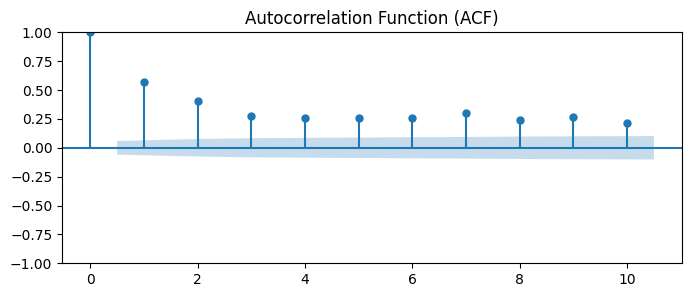

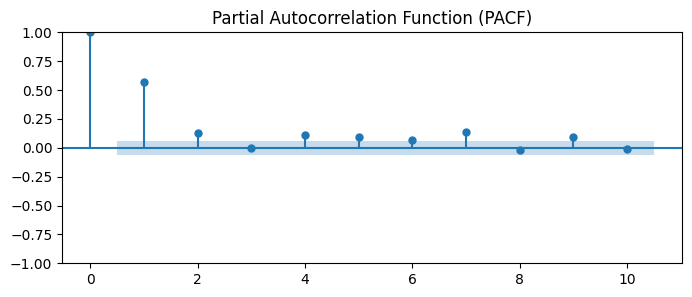

In [34]:
# plot the ACF
fig, ax = plt.subplots(figsize=(8,3))
sm.graphics.tsa.plot_acf(df_day, lags=10, ax=ax)
ax.set(title='Autocorrelation Function (ACF)')
# plot the PACF
fig, ax = plt.subplots(figsize=(8,3))
sm.graphics.tsa.plot_pacf(df_day, lags=10, ax=ax)
ax.set(title='Partial Autocorrelation Function (PACF)')

plt.show()

## *Chosen parameters: p=1, d=0, q=1*
* The series appears to be stationary, then d=0
* In the PACF plot, the significant spike is at lag 1, so p=1
* In the ACF plot, the significant spike is at lag 1, so q=1

## Splitting dataset 

In [35]:
# Set the training set size to 80% and the testing set size to 20%
train_size = int(len(df_day) * 0.8)
test_size = len(df_day) - train_size

# split the data into training and testing sets
train_data, test_data = df_day.iloc[:train_size], df_day.iloc[train_size:]

# print the shapes of the training and testing sets
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (876, 1)
Testing data shape: (220, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Occurrence   No. Observations:                  876
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4879.140
Date:                Thu, 11 May 2023   AIC                           9766.280
Time:                        08:28:10   BIC                           9785.381
Sample:                    01-01-2020   HQIC                          9773.586
                         - 05-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        571.9271      9.748     58.669      0.000     552.821     591.034
ar.L1          0.8547      0.022     39.261      0.000       0.812       0.897
ma.L1         -0.5102      0.035    -14.438      0.0

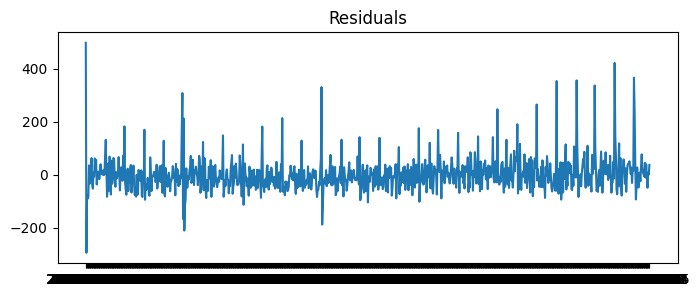

2022-05-26    594.255019
2022-05-27    591.010081
2022-05-28    588.236734
2022-05-29    585.866440
2022-05-30    583.840623
2022-05-31    582.109220
2022-06-01    580.629443
2022-06-02    579.364724
2022-06-03    578.283808
2022-06-04    577.359982
Freq: D, Name: predicted_mean, dtype: float64


In [36]:

# create the ARIMA model
model = sm.tsa.ARIMA(train_data, order=(1, 0, 1))

# fit the ARIMA model
results = model.fit()

# print the model summary
print(results.summary())

# plot the residuals
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(results.resid)
ax.set(title='Residuals')
plt.show()

# make predictions
forecast = results.forecast(steps=10)
print(forecast)


#	Evaluate the Model: Evaluate the performance of the ARIMA model

Mean squared error (MSE): 15055.97428031186
Mean absolute error (MAE): 74.53525957273489
Root mean squared error (RMSE): 122.70278839664509


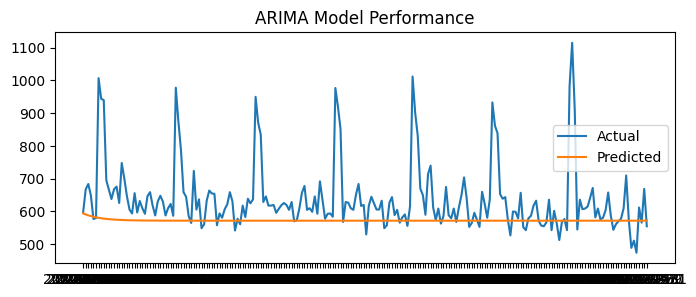

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# make predictions
forecast = results.forecast(steps=len(test_data))

# evaluate the model
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mse)
print("Mean squared error (MSE):", mse)
print("Mean absolute error (MAE):", mae)
print("Root mean squared error (RMSE):", rmse)

# plot the predicted values and the actual values
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(test_data.index, test_data, label='Actual')
ax.plot(test_data.index, forecast, label='Predicted')
ax.set(title='ARIMA Model Performance')
ax.legend()
plt.show()




**The predictions of the ARIMA model went around 600 cases, and it didn't capture the pattern of the high number of occurrences on the first day of every month. MAE is 74, which is relatively high, which means the models often couldn't predict precisely in a range of 10 cases of error.**

# RNN model for time series

In [38]:
#Reading the data
df_day = pd.read_csv('day_time_series.csv')

### Training the RNN model

In [39]:
#Import libraru
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_day['Occurrence'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


# Function to create time series dataset
def create_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        Y.append(data[i + window_size])
    return np.array(X), np.array(Y)

# Set the window size for creating the dataset
window_size = 10

# Create the training dataset
train_X, train_Y = create_dataset(train_data, window_size)

# Create the testing dataset
test_X, test_Y = create_dataset(test_data, window_size)

# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(window_size, 1)),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(train_X, train_Y, epochs=100, batch_size=32)


Epoch 1/100
30/30 [==============================] - 2s 7ms/step - loss: 0.0332
Epoch 2/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 3/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0046
Epoch 4/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 5/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 6/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 7/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 8/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0046
Epoch 9/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0047
Epoch 10/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 11/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 12/100
30/30 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 13/100
30/30 [=================

## Showing the model performance

In [40]:
# Make predictions on the testing data
predictions = model.predict(test_X)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
test_Y = scaler.inverse_transform(test_Y)

# Retrieve the original dates and occurrences for the test data
test_dates = df_day['Day'].values[train_size + window_size:train_size + window_size + len(test_X)]
test_occurrences = df_day['Occurrence'].values[train_size + window_size:train_size + window_size + len(test_X)]

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions - test_Y) ** 2))
print('RMSE:', rmse)

# Print the predicted values, dates, and occurrences
print('Predicted Values, Dates, and Occurrences:')
for i in range(len(predictions)):
    print('Date:', test_dates[i], 'Predicted Value:', predictions[i][0], 'Original Value:', test_occurrences[i])

8/8 [==============================] - 0s 3ms/step
RMSE: 90.35209643928624
Predicted Values, Dates, and Occurrences:
Date: 2022-08-13 Predicted Value: 631.1196 Original Value: 620
Date: 2022-08-14 Predicted Value: 623.4758 Original Value: 605
Date: 2022-08-15 Predicted Value: 615.95483 Original Value: 629
Date: 2022-08-16 Predicted Value: 624.0259 Original Value: 570
Date: 2022-08-17 Predicted Value: 600.8756 Original Value: 573
Date: 2022-08-18 Predicted Value: 596.7904 Original Value: 609
Date: 2022-08-19 Predicted Value: 610.9139 Original Value: 657
Date: 2022-08-20 Predicted Value: 634.7356 Original Value: 678
Date: 2022-08-21 Predicted Value: 648.6212 Original Value: 605
Date: 2022-08-22 Predicted Value: 619.5589 Original Value: 610
Date: 2022-08-23 Predicted Value: 615.50775 Original Value: 599
Date: 2022-08-24 Predicted Value: 611.0886 Original Value: 646
Date: 2022-08-25 Predicted Value: 631.5439 Original Value: 593
Date: 2022-08-26 Predicted Value: 613.5642 Original Value: 692

**RNN model based on the historical data (previous days) to make predictions. However, the pattern of a significant number of events on the first day of each month was not captured by the RNN model. Sometimes, it performed so well at prediction, sometimes it didn't.**